In [7]:
import os
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import numpy as np
import pandas as pd

In [8]:
WD = '/local/meliao/projects/fourier_neural_operator/experiments/09_predict_residuals/'
os.chdir(WD)
print(os.getcwd())

/local/meliao/projects/fourier_neural_operator/experiments/09_predict_residuals


In [9]:
from train_models import SpectralConv1d, FNO1dComplexTime, TimeDataSetResiduals

In [25]:
TRAIN_DF = '/local/meliao/projects/fourier_neural_operator/experiments/09_predict_residuals/results/00_residual_train.txt'
TEST_DF = '/local/meliao/projects/fourier_neural_operator/experiments/09_predict_residuals/results/00_residual_test.txt'
DATA_FP = '/local/meliao/projects/fourier_neural_operator/data/2021-06-24_NLS_data_04_test.mat'
MODEL_FP = '/local/meliao/projects/fourier_neural_operator/experiments/09_predict_residuals/models/00_residual_ep_500'
BASELINE_FP = '/local/meliao/projects/fourier_neural_operator/experiments/08_FNO_pretraining/models/00_pretrain_ep_1000'


In [14]:
train_df = pd.read_table(TRAIN_DF)
test_df = pd.read_table(TEST_DF)

In [15]:
def make_train_test_plot(a_train, a_test, fp=None):
    fig, ax = plt.subplots(1, 2, sharey=False)


    # a_train and a_test are the time-dependent FNO data. They're in the first column
    ax[0].set_title("Train")
    ax[0].plot(a_train.epoch, a_train.MSE, '-', color='red', label='train')
    ax[1].plot(a_test.epoch, a_test.test_mse, '--', color='red', label='test')
    ax[0].set_xlabel("Epoch", fontsize=13)
    ax[1].set_xlabel("Epoch", fontsize=13)
    # ax[0].legend()
    # ax[0].set_yscale('log')

    ax[0].set_ylabel("MSE", fontsize=13)

    # b_train and b_test are the time-dependent. They're in the seecond column
    ax[1].set_title("Test")
    # ax[1].plot(b_train.epoch, b_train.MSE, '-', color='blue', label='train')
    # ax[1].plot(b_test.epoch, b_test.test_mse, '--', color='blue', label='test')
    ax[1].set_xlabel("Epoch", fontsize=13)
    ax[1].set_yscale('log')
    # ax[1].legend(fontsize=13)


    plt.tight_layout()

    if fp is not None:
        plt.savefig(fp)
    else:
        plt.show()
    plt.close(fig)

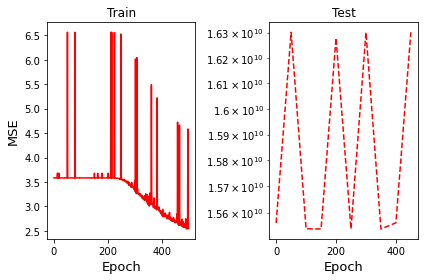

In [16]:
make_train_test_plot(train_df, test_df)

In [26]:
d = sio.loadmat(DATA_FP)
model = torch.load(MODEL_FP, map_location='cpu')
emulator = torch.load(BASELINE_FP, map_location='cpu')

In [28]:
test_dset = TimeDataSetResiduals(d['output'], d['t'], d['x'], emulator)